In [58]:
import sys
sys.path.append('..')
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import pyro
from utils import *

Define prior on $\theta$

In [59]:
d = 1
sigma_theta =torch.eye(d)
mu_theta =torch.zeros(d)
prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta) 
prior_log_prob = lambda samples: prior_distribution.log_prob(samples)

Generate $D_\theta$ according to some prior distribution

In [60]:
n_D = 5
D_theta =torch.linspace(-4,-3, n_D).unsqueeze(-1)

Generate $D_x$ according to some unknown linear $f(D_\theta)$

In [61]:
sigma_simulateur = .5
f = lambda y: 1*torch.ones(d)@y.T+1
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*sigma_simulateur

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [62]:
theta_0 = prior_distribution.sample()
theta_0 = torch.tensor([1.])
print('theta_0 = ' + str(theta_0.item()))
n_x0= 5
x0 = simulateur(theta_0.unsqueeze(0).repeat(n_x0, 1))

theta_0 = 1.0


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

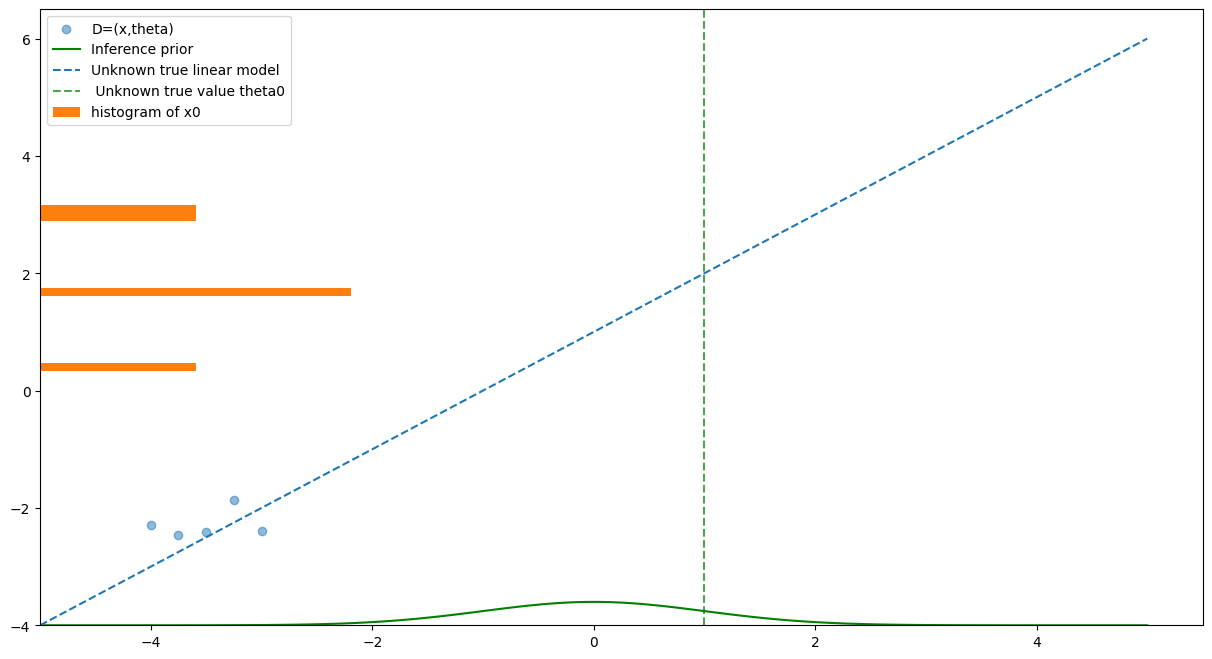

In [63]:
plt.figure(figsize = (15,8))
y_min = -4
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
tt = torch.linspace(-5,5,100)
plt.plot(tt, y_min + torch.exp(prior_distribution.log_prob(tt.unsqueeze(-1))), color = 'green', label='Inference prior')
plt.plot(tt.numpy(),f(tt.unsqueeze(-1)).numpy(), linestyle = '--', label = 'Unknown true linear model')
plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [64]:
class bayesian_linear_regression:
    def __init__(self, x_samples, theta_samples, x0, sigma_simulateur, mu_theta, sigma_theta): 
        self.x_samples = x_samples
        self.theta_samples = theta_samples
        self.num_samples = x_samples.shape[0]
        self.d = theta_samples.shape[-1]
        
        self.sigma_simulateur = sigma_simulateur
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta 
        
        self.mu_phi = torch.zeros(self.d+1)
        self.sigma_phi = torch.eye(self.d+1)

        self.mu_phi_D, self.sigma_phi_D = self.compute_parameter_posterior_parameter()
        self.parameter_posterior_distribution = torch.distributions.MultivariateNormal(self.mu_phi_D, self.sigma_phi_D)
        self.x0=x0
    
    def compute_parameter_likelihood(self, D_theta, D_x):
        assert D_theta.shape[0]>=2,'Must have more than 1 dataset sample'
        assert D_theta.shape[0]==D_x.shape[0], 'Mismatch in number samples'
        temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
        sigma_d_phi = torch.inverse(temp.T@temp)*self.sigma_simulateur**2
        mu_d_phi = D_x@temp@torch.inverse(temp.T@temp)
        return mu_d_phi,sigma_d_phi 

    def dataset_likelihood(self, beta): 
        assert self.num_samples>=1,'No dataset'
        temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
        mean = beta@temp.T
        sigma = (self.sigma_simulateur**2)*torch.eye(self.d).unsqueeze(0).repeat(self.theta_samples.shape[0],1,1)
        return torch.distributions.MultivariateNormal(mean.unsqueeze(-1),sigma).log_prob(self.x_samples.unsqueeze(-1))
        
    def compute_parameter_posterior_parameter(self, D_theta= None, D_x = None):
        if D_theta is None:
            D_theta = self.theta_samples
        if D_x == None: 
            D_x = self.x_samples
        assert D_theta.shape[0] == D_x.shape[0],'Mismatch in number samples'
        if D_theta.shape[0]>=1:
            temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
            sigma_phi_d = torch.inverse(temp.T@temp/self.sigma_simulateur**2 + torch.inverse(self.sigma_phi))
            mu_phi_d = sigma_phi_d@(D_x@temp/self.sigma_simulateur**2+ torch.inverse(self.sigma_phi)@self.mu_phi)
        else:
            mu_phi_d, sigma_phi_d = self.mu_phi, self.sigma_phi 
        return mu_phi_d,sigma_phi_d
        

    def log_joint_distribution(self, theta, phi):
        log_prior = torch.distributions.MultivariateNormal(self.mu_theta, self.sigma_theta).log_prob(theta)
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def marginal_log_likelihood_parameters(self, x, theta): 
        mu_phi_d, sigma_phi_d = self.compute_parameter_posterior_parameter()
        gamma = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1).unsqueeze(1).repeat(1,x.shape[0],1)
        mean = gamma@mu_phi_d
        cov = gamma@sigma_phi_d.unsqueeze(0).repeat(theta.shape[0],1,1)@torch.transpose(gamma, -2,-1) + self.sigma_simulateur*torch.eye(x.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        return mean, cov
    
    def marginal_log_likelihood(self, x, theta):
        mean, cov = self.marginal_log_likelihood_parameters(x, theta)
        return torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
    
    def sample_marginal_likelihood(self, num_samples, theta):
        mean, cov = self.marginal_log_likelihood_parameters(torch.zeros(num_samples), theta)
        return torch.distributions.MultivariateNormal(mean, cov).sample()
    
    def compute_posterior_distribution_parameters(self,beta):
        sigma_theta_x0_phi = torch.inverse(torch.inverse(self.sigma_theta) + (self.x0.shape[0]*beta[0]**2)/self.sigma_simulateur**2)
        mu_theta_x0_phi = sigma_theta_x0_phi@(torch.inverse(self.sigma_theta)@self.mu_theta + beta[0]*torch.sum(self.x0 - beta[1])/self.sigma_simulateur**2)
        return mu_theta_x0_phi, sigma_theta_x0_phi 

Sample joint with Gibbs sampling

In [74]:
blr = bayesian_linear_regression(D_x, D_theta, x0, sigma_simulateur, mu_theta, sigma_theta)
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
current_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample()
mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
list_theta_gibbs = []
list_phi_gibbs = []

for t in tqdm(range(50000)):
    current_Theta = current_theta.unsqueeze(0).repeat(x0.shape[0],1)
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_parameter_posterior_parameter(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
    list_theta_gibbs.append(current_theta)
    list_phi_gibbs.append(current_phi)
print(torch.stack(list_phi_gibbs).shape)
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_theta_gibbs).unsqueeze(1),chain_dim = 1, sample_dim =0))
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_gibbs)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:43<00:00, 305.30it/s]


torch.Size([50000, 2])
ESS theta  tensor([3593.5679])
ESS theta  tensor(68102.4766)


In [38]:
blr = bayesian_linear_regression(D_x, D_theta, x0, sigma_simulateur, mu_theta, sigma_theta)
list_theta = []
list_phi = []
for t in tqdm(range(10000)):
    mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
    list_theta.append(current_theta)
    list_phi.append(current_phi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 878.30it/s]


In [66]:
prior_phi = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
from tqdm import tqdm
def sample_joint_IMH(number_steps, number_chains):
    current_phi = prior_phi.sample([number_chains])
    current_theta = prior_distribution.sample([number_chains])
    for _ in tqdm(range(number_steps)):
        proposed_phi = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample([number_chains])
        proposed_theta = prior_distribution.sample([number_chains])
        acceptance_log_prob = blr.log_joint_distribution(proposed_theta,proposed_phi)+prior_distribution.log_prob(current_theta) + prior_phi.log_prob(current_phi) - blr.log_joint_distribution(current_theta,current_phi) -prior_distribution.log_prob(proposed_theta) - prior_phi.log_prob(proposed_phi)
        mask = ((torch.rand(number_chains) < torch.exp(acceptance_log_prob)) * 1.).unsqueeze(-1)
        current_phi = (mask)*proposed_phi + (1-(mask))*current_phi
        current_theta = (mask)*proposed_theta + (1-(mask))*current_theta
    return current_phi, current_theta

In [71]:
phi_samples, theta_samples = sample_joint_IMH(200,5000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.00it/s]


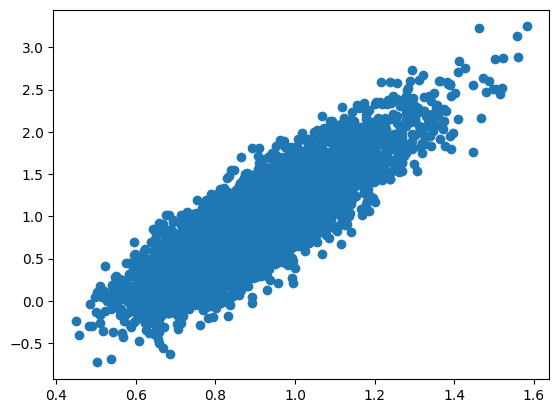

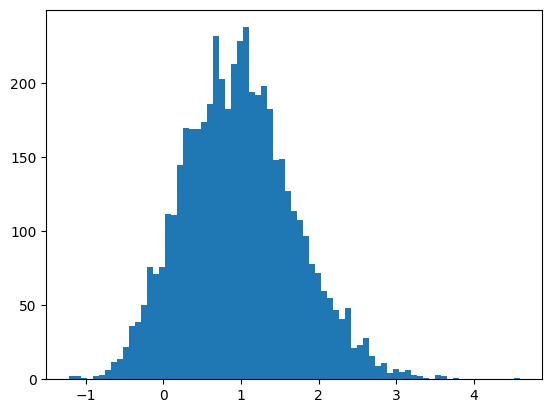

In [73]:
plt.scatter(phi_samples[:,0], phi_samples[:,1])
plt.show()
plt.hist(theta_samples.numpy(), bins = 150)
plt.show()

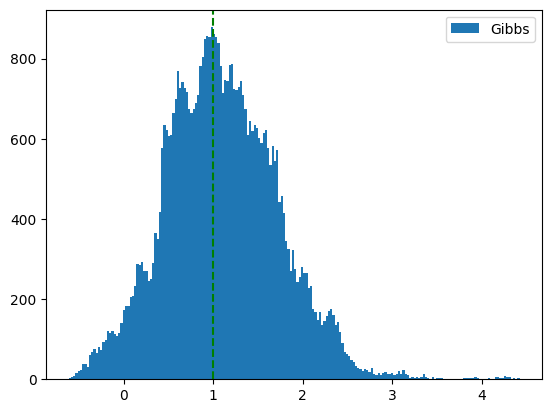

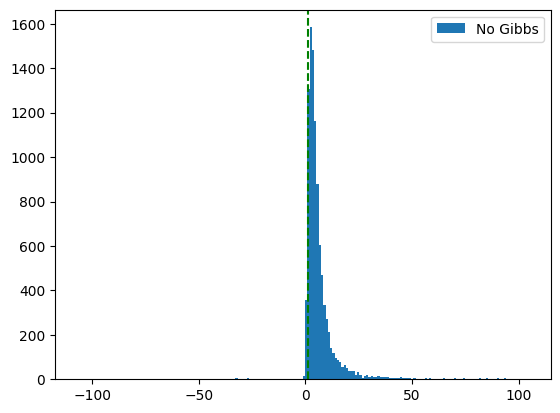

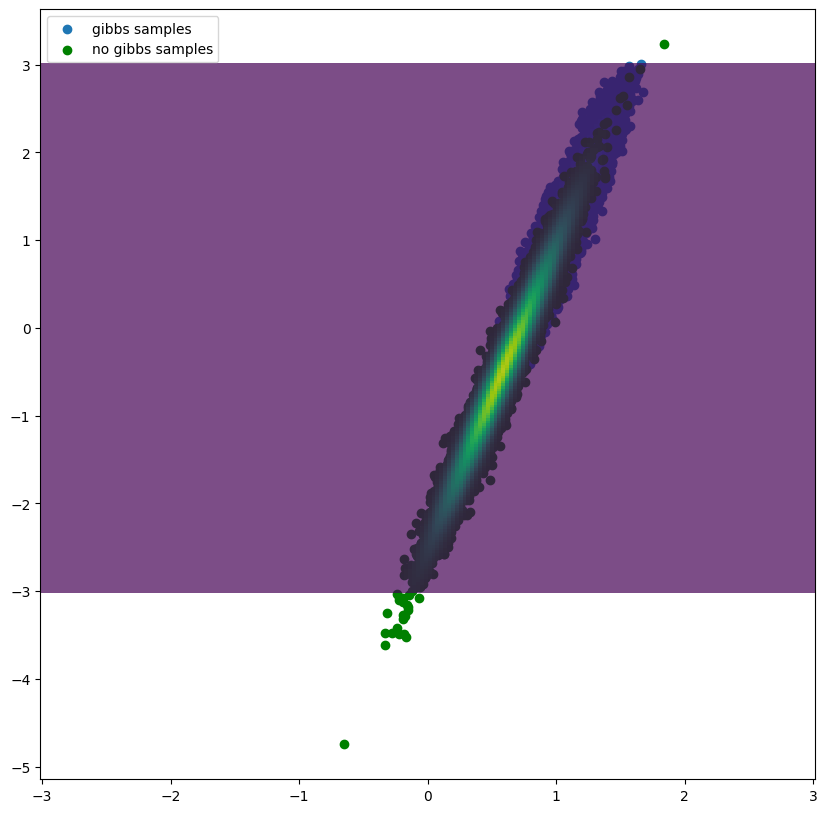

In [39]:
models_phi_gibbs = torch.stack(list_phi_gibbs, dim=0)
hist=plt.hist(torch.cat(list_theta_gibbs, dim = 0).numpy(), bins= 200, label = 'Gibbs')
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.legend()
plt.show()

models_phi = torch.stack(list_phi, dim=0)
hist=plt.hist(torch.cat(list_theta, dim = 0).numpy(), bins= 200, label = 'No Gibbs')
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
plt.scatter(models_phi_gibbs[:,0].numpy(), models_phi_gibbs[:,1].numpy(), label = 'gibbs samples')
plt.scatter(models_phi[:,0].numpy(), models_phi[:,1].numpy(), label = 'no gibbs samples', color = 'green')
plot_2d_function(lambda samples:torch.exp(blr.parameter_posterior_distribution.log_prob(samples)),[[-3,3],[-3,3]], [200,200])
plt.legend()
plt.show()

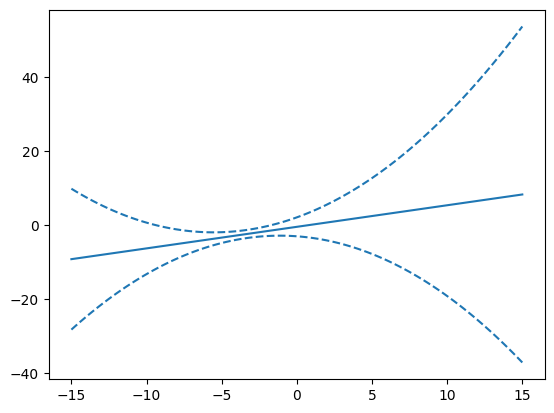

In [36]:
tt = torch.linspace(-15,15,100)
mean, cov =  blr.marginal_log_likelihood_parameters(torch.zeros(1), tt.unsqueeze(-1))
plt.plot(tt, mean)
plt.plot(tt,mean.squeeze(-1) + 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle = '--')
plt.plot(tt,mean.squeeze(-1) - 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle= '--')
sample = blr.sample_marginal_likelihood(10,tt.unsqueeze(-1))